In [1]:
import tensorflow as tf
import numpy as np
import time
import scipy.io as sio
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.initializers import Constant
from tensorflow.keras import backend
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [3]:
!python3 -m pip install opencv-python

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [2]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
image=cv2.imread()
cv2.resize(image,((1024,1024)))
cv2.imshow('image',image)
cv2.waitKey(0)

In [2]:
from PIL import Image
  
# open method used to open different extension image file
im = Image.open(r"C:/Users/rome/Downloads/Compressed Imaging-20230611T071736Z-001/Compressed Imaging/data_test/Monarch1024.tif") 
  
# This method will show image in any image viewer 
im.show() 

In [3]:
### This version is for forward model testing, and non-trainable
class Doublet_Metalens_EDOF:
    
    def encoder_forward(inputs):
        #def __init__(self):
            #optimizer = Adam(learning_rate=5e-4)
        #self.Doublet_Metalens_EDOF = self.encoder_forward()
        R_AL = 156.41968e-6 # Radius of Aperture Meta-lens (unit: m)
        R_FL = 321.4889e-6 # Radius of Focusing Meta-lens (unit: m)
        S = 320e-9 # Distance between Two Opposite Sides of a Nanofin (unit: m). This value is for determing the resolution of the two metalens.
        delta_2D = np.zeros([1,1024,1024,1],dtype=np.float32) 
        delta_2D[0,511:513,511:513,0] = 1 # To calculate the PSF
        lambda_d = 532e-9 # Design Wavelength (unite: m)
        f = 342.3e-6 # Focal Length (unite: m)
        z1 = 5e-4 # Thickness of SiO2 glass (unite: m)
        z2 = 100e-3 # Distance between the Meta-lens and the sensor (unite: m)
            #def rmse(y_true, y_pred):
            #    return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
            #self.Doublet_Metalens_EDOF.compile(optimizer=optimizer, loss='mean_squared_error',metrics=rmse)
        def phi_AL(a, R_AL, S):
            x = np.linspace(-R_AL,R_AL,num = int(R_AL/S))            
            y = x
            X, Y = np.meshgrid(x, y)
            PHI_AL = a.numpy()[0][0][0]*(np.sqrt(X*X+Y*Y)/R_AL)**2 + a.numpy()[0][0][1]*(np.sqrt(X*X+Y*Y)/R_AL)**4 + \
            a.numpy()[0][0][2]*(np.sqrt(X*X+Y*Y)/R_AL)**6 + a.numpy()[0][0][3]*(np.sqrt(X*X+Y*Y)/R_AL)**8 + \
            a.numpy()[0][0][4]*(np.sqrt(X*X+Y*Y)/R_AL)**10
            
            print('Coefficients a: ',a)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_AL[int(R_AL/S/2),:]/2/3.141592653) 
            plt.title('Phase profile of the aperture meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            return PHI_AL
            
        def phi_FL(b, R_FL, S):
            x = np.linspace(-R_FL,R_FL,num = int(R_FL/S))
            y = x
            X, Y = np.meshgrid(x, y)
            PHI_FL = -2*3.141592653/lambda_d*(np.sqrt(X*X+Y*Y+f*f)-f) + b.numpy()[0][0][0]*(np.sqrt(X*X+Y*Y)/R_FL)**2 + \
            b.numpy()[0][0][1]*(np.sqrt(X*X+Y*Y)/R_FL)**4 + b.numpy()[0][0][2]*(np.sqrt(X*X+Y*Y)/R_FL)**6 + \
            b.numpy()[0][0][3]*(np.sqrt(X*X+Y*Y)/R_FL)**8 + b.numpy()[0][0][4]*(np.sqrt(X*X+Y*Y)/R_FL)**10
            
            print('Coefficients b: ',b)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_FL[int(R_FL/S/2),:]/2/3.141592653) 
            plt.title('Phase profile of the focusing meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            return PHI_FL
            
        inputs = Input(shape=(1,1))
        ### Aperture Meta-lens
        a = Dense(5,use_bias=False,kernel_initializer =Constant([-13.5078, 22.5578, -5.3161, 6.8526, -2.1028]))(inputs) # See Table S1
        PHI_AL = phi_AL(a, R_AL, S)
        print('Size in pixels of aperture meta-lens phase profile: ',PHI_AL.shape)
        Phase_AL = Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_AL), PHI_AL))
        x = np.linspace(-R_AL,R_AL,num = int(R_AL/S))            
        y = x
        X, Y = np.meshgrid(x, y)
        PSF_AL = Lambda(tf.signal.fft2d)(Phase_AL*Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_AL), 3.141592653/lambda_d/z1*(X*X+Y*Y))))
        PSF_AL = Lambda(backend.abs)(PSF_AL)
        PSF_AL = PSF_AL*PSF_AL
        
        fft_length = PSF_AL.shape[0]
        PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_AL_final = PSF_final
        PSF_AL_final = np.float32(np.expand_dims(np.expand_dims(PSF_AL_final,2),3))
        u1 = backend.conv2d(delta_2D, PSF_AL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        ### Focusing Meta-lens
        b = Dense(5,use_bias=False,kernel_initializer = Constant([-50.0228, -391.0979, 153.7385, -45.8029, 5.7907]))(inputs) # See Table S2
        PHI_FL = phi_FL(b, R_FL, S)
        print('Size in pixels of focusing meta-lens phase profile: ',PHI_FL.shape)
        Phase_FL = Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_FL), PHI_FL))
        x = np.linspace(-R_FL,R_FL,num = int(R_FL/S))            
        y = x
        X, Y = np.meshgrid(x, y)
        PSF_FL = Lambda(tf.signal.fft2d)(Phase_FL*Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_FL), 3.141592653/lambda_d/z2*(X*X+Y*Y))))
        PSF_FL = Lambda(backend.abs)(PSF_FL)
        PSF_FL = PSF_FL*PSF_FL
        fft_length = PSF_FL.shape[0]
        PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_FL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_FL[0:int(fft_length/2),0:int(fft_length/2)]
        PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_FL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_FL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_FL_final = PSF_final
        PSF_FL_final = np.float32(np.expand_dims(np.expand_dims(PSF_FL_final,2),3))
        u2 = backend.conv2d(u1, PSF_FL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        outputs = Lambda(lambda x:(x-backend.min(x))/(backend.max(x)-backend.min(x)))(u2)
        return outputs

        
        

In [7]:
start_time = time.time()

Input= np.array(im)
Input= Input[np.newaxis,:,:,np.newaxis]
#Input = np.ones((1,1,1),dtype=np.float32)
output = Doublet_Metalens_EDOF.encoder_forward(Input)

plt.figure(figsize=(5, 5)) 
plt.imshow(np.squeeze(output),cmap='jet')
plt.colorbar()
plt.title('Output')
plt.axis('off') 
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

ValueError: operands could not be broadcast together with shapes (5,) (488,488) 

In [4]:
### This version is for training
class Doublet_Metalens_EDOF:
    def __init__(self):
        self.channels = 1
        #self.input_size = 1
        self.input_size_x = 1024 # input size 1x1024x1024x1
        self.input_size_y = 1024 # input size 1x1024x1024x1
        self.input_shape = (self.input_size_x,self.input_size_y, self.channels)
        self.R_AL = 156.41968e-6 # Radius of Aperture Meta-lens (unit: m)
        self.R_FL = 321.4889e-6 # Radius of Focusing Meta-lens (unit: m)
        self.S = 320e-9 # Distance between Two Opposite Sides of a Nanofin (unit: m). This value is for determing the resolution of the two metalens.
       # self.delta_2D = np.zeros([1,1024,1024,1],dtype=np.float32) 
       # self.delta_2D[0,511:513,511:513,0]        = 1 # To calculate the PSF
        #self.delta_2D = np.zeros([1,51,51,1],dtype=np.float32) 
        #self.delta_2D[0,26,26,0] = 1 # To calculate the PSF
        self.lambda_d = 532e-9 # Design Wavelength (unite: m)
        self.f = 342.3e-6 # Focal Length (unite: m)
        self.z1 = 5e-4 # Thickness of SiO2 glass (unite: m)
        self.z2 = 100e-3 # Distance between the Meta-lens and the sensor (unite: m)
        optimizer = Adam(learning_rate=1e-2)
        self.Doublet_Metalens_EDOF = self.encoder_forward()
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
        self.Doublet_Metalens_EDOF.compile(optimizer=optimizer, loss='mean_squared_error',metrics=rmse)
    
    def encoder_forward(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        print('*****Shape of the self.input_shape*****',self.input_shape)
        def phi_AL(a, R_AL, S):
            x = tf.linspace(-R_AL,R_AL,int(R_AL/S))
            y = x
            X, Y = tf.meshgrid(x, y)
            dense1 = Dense(1,use_bias=False,kernel_initializer =Constant([1,0,0,0,0]),trainable=False)
            a1 = Flatten()(dense1(a))
            dense2 = Dense(1,use_bias=False,kernel_initializer =Constant([0,1,0,0,0]),trainable=False)
            a2 = Flatten()(dense2(a))
            dense3 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,1,0,0]),trainable=False)
            a3 = Flatten()(dense3(a))
            dense4 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,1,0]),trainable=False)
            a4 = Flatten()(dense4(a))
            dense5 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,0,1]),trainable=False)
            a5 = Flatten()(dense5(a))

            PHI_AL = a1*(tf.math.sqrt(X*X+Y*Y)/R_AL)**2 + a2*(tf.math.sqrt(X*X+Y*Y)/R_AL)**4 + \
            a3*(tf.math.sqrt(X*X+Y*Y)/R_AL)**6 + a4*(tf.math.sqrt(X*X+Y*Y)/R_AL)**8 + \
            a5*(tf.math.sqrt(X*X+Y*Y)/R_AL)**10
            '''
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_AL[int(R_AL/S/2),:]/2/np.pi) 
            plt.title('Phase profile of the aperture meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            '''
            return PHI_AL
            
        def phi_FL(b, R_FL, S):
            x = tf.linspace(-R_FL,R_FL,int(R_FL/S))
            y = x
            X, Y =tf.meshgrid(x, y)
            dense1 = Dense(1,use_bias=False,kernel_initializer =Constant([1,0,0,0,0]),trainable=False)
            b1 = Flatten()(dense1(b))
            dense2 = Dense(1,use_bias=False,kernel_initializer =Constant([0,1,0,0,0]),trainable=False)
            b2 = Flatten()(dense2(b))
            dense3 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,1,0,0]),trainable=False)
            b3 = Flatten()(dense3(b))
            dense4 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,1,0]),trainable=False)
            b4 = Flatten()(dense4(b))
            dense5 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,0,1]),trainable=False)
            b5 = Flatten()(dense5(b))
            PHI_FL = -2*3.141592653/self.lambda_d*(tf.math.sqrt(X*X+Y*Y+self.f*self.f)-self.f) + b1*(tf.math.sqrt(X*X+Y*Y)/R_FL)**2 + \
            b2*(tf.math.sqrt(X*X+Y*Y)/R_FL)**4 + b3*(tf.math.sqrt(X*X+Y*Y)/R_FL)**6 + \
            b4*(tf.math.sqrt(X*X+Y*Y)/R_FL)**8 + b5*(tf.math.sqrt(X*X+Y*Y)/R_FL)**10
            '''
            print('Coefficients b: ',b)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_FL[int(R_FL/S/2),:]) 
            plt.title('Phase profile of the focusing meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            '''
            return PHI_FL
            
        
        ### Aperture Meta-lens
        Identity= tf.constant(1, shape = (1,1))
        a = Dense(5,use_bias=False,kernel_initializer =Constant([-13.5078, 22.5578, -5.3161, 6.8526, -2.1028]))(Identity) # See Table S1
        PHI_AL = phi_AL(a, self.R_AL, self.S)
        Phase_AL = Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_AL), PHI_AL))
        x = np.linspace(-self.R_AL,self.R_AL,num = int(self.R_AL/self.S)) 
        
        y = x
        X, Y = tf.meshgrid(x, y)
        PSF_AL = Lambda(tf.signal.fft2d)(Phase_AL*Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_AL,dtype=tf.float32), tf.cast(3.141592653/self.lambda_d/self.z1*(X*X+Y*Y),dtype=tf.float32))))
        PSF_AL = Lambda(tf.signal.fftshift)(PSF_AL)
        PSF_AL = Lambda(backend.abs)(PSF_AL)
        PSF_AL = PSF_AL*PSF_AL
        #fft_length = PSF_AL.shape[0]
        #PSF_final = tf.zeros([fft_length,fft_length]) # Fourer Transform
        #PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        #PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        #PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        #PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_AL_final = PSF_AL
        PSF_AL_final = tf.expand_dims(tf.expand_dims(PSF_AL_final,0),3)
        PSF_AL_final = AveragePooling2D(pool_size=(20,20), strides = (20,20))(PSF_AL_final)
        PSF_AL_final = tf.transpose(PSF_AL_final, [1,2,0,3])       
        u1 = backend.conv2d(inputs, PSF_AL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        ### Focusing Meta-lens
        b = Dense(5,use_bias=False,kernel_initializer = Constant([-50.0228, -391.0979, 153.7385, -45.8029, 5.7907]))(Identity) # See Table S2
        PHI_FL = phi_FL(b, self.R_FL, self.S)
        x = tf.linspace(-self.R_FL,self.R_FL, int(self.R_FL/self.S))            
        y = x
        X, Y = tf.meshgrid(x, y)
        Phase_FL = Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_FL), PHI_FL))
        PSF_FL = Lambda(tf.signal.fft2d)(Phase_FL*Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_FL,dtype=tf.float32),  tf.cast(np.pi/self.lambda_d/self.z2*(X*X+Y*Y),dtype=tf.float32))))
        PSF_FL = Lambda(tf.signal.fftshift)(PSF_FL)
        PSF_FL = Lambda(backend.abs)(PSF_FL)
        PSF_FL = PSF_FL*PSF_FL
        #fft_length = PSF_FL.shape[0]
        #PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        #PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        #PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        #PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        #PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_FL_final = PSF_FL
        PSF_FL_final = tf.expand_dims(tf.expand_dims(PSF_FL_final,0),3)
        PSF_FL_final = AveragePooling2D(pool_size=(20,20), strides = (20,20))(PSF_FL_final)
        PSF_FL_final = tf.transpose(PSF_FL_final, [1,2,0,3])
        u2 = backend.conv2d(u1, PSF_FL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        
        outputs = Lambda(lambda x:(x-backend.min(x))/(backend.max(x)-backend.min(x)))(u2) 
        print('*****Shape of the output layer*****',outputs.shape)
        '''
        plt.figure(figsize=(5, 5)) 
        plt.imshow(np.squeeze(output),cmap='gray')
        plt.colorbar()
        plt.title('Output')
        plt.axis('off') 
        plt.show()
        '''
        print('*****Shape of the output layer*****',outputs.shape)
        return Model(inputs = inputs, outputs = outputs)
    
    def train(self, X, Y, epochs, batch_size=1):
        self.Doublet_Metalens_EDOF.summary()
        for i in range(epochs):
            
            start_time = time.time()
            
            loss, error = self.Doublet_Metalens_EDOF.train_on_batch(X, Y)
            print('Epoch: ',i+1,'/',epochs,', loss: ', loss,'Mean absoluate error: ',error)
#             print('Coefficients a: ',self.Doublet_Metalens_EDOF.layers[1].get_weights()[0])
#             print('Coefficients b: ',self.Doublet_Metalens_EDOF.layers[2].get_weights()[0])
            print('*****Shape of the X*****',X.shape)
            pred = self.Doublet_Metalens_EDOF.predict_on_batch(X)
            print(pred.shape)
#             plt.figure(figsize=(3, 3)) 
#             plt.plot(pred[0,50,:]) 
#             plt.title('Phase profile of the aperture meta-lens')
#             plt.xlabel('Radial coordinate (unit: um)')
#             plt.ylabel('Phase profile (2*pi)')
#             plt.show()

            plt.figure(figsize=(10, 5))
            plt.subplot(1,2,1)
            plt.imshow(np.squeeze(pred),cmap='jet')
            plt.colorbar()
            plt.title('Output')
            plt.axis('off') 
            plt.subplot(1,2,2)
            plt.imshow(np.squeeze(Y),cmap='jet')
            plt.colorbar()
            plt.title('GT')
            plt.axis('off') 
            plt.show()
            print("--- %s seconds for epoch ---" % (time.time() - start_time))
        self.Doublet_Metalens_EDOF.save('Doublet_Metalens_EDOF.h5')
        
    #def test:
        
        

*****Shape of the GT***** (1, 1, 1024, 1, 1024, 1)
*****Shape of the Input***** (1, 1024, 1024, 1)
*****Shape of the self.input_shape***** (1024, 1024, 1)
*****Shape of the output layer***** (None, 1024, 1024, 1)
*****Shape of the output layer***** (None, 1024, 1024, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 1)]   0         
_________________________________________________________________
tf.compat.v1.nn.convolution  (None, 1024, 1024, 1)     0         
_________________________________________________________________
tf.compat.v1.nn.convolution_ (None, 1024, 1024, 1)     0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 1024, 1024, 1)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
____________________________________________________________

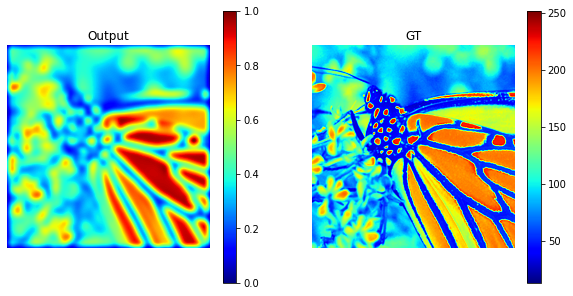

--- 2.3950765132904053 seconds for epoch ---
Epoch:  2 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


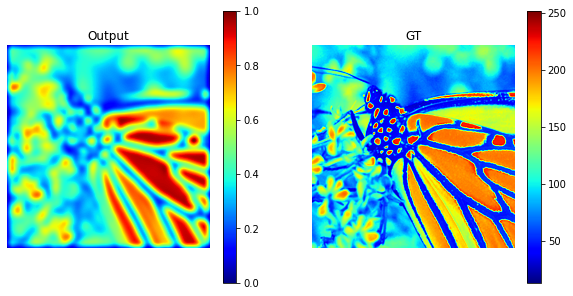

--- 2.103999137878418 seconds for epoch ---
Epoch:  3 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


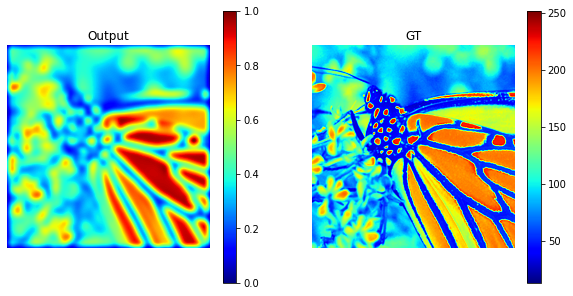

--- 2.0949997901916504 seconds for epoch ---
Epoch:  4 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


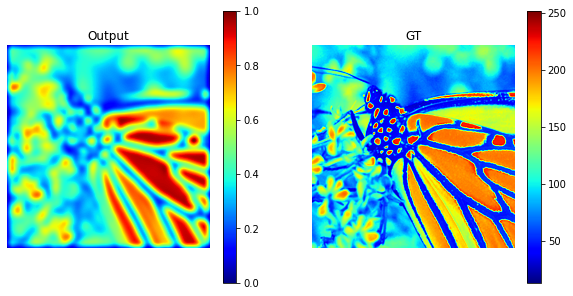

--- 2.0819995403289795 seconds for epoch ---
Epoch:  5 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


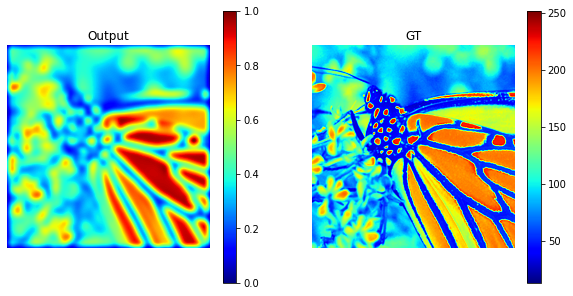

--- 2.0930004119873047 seconds for epoch ---
Epoch:  6 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


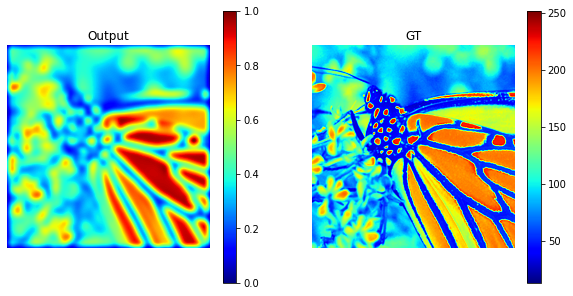

--- 2.0430002212524414 seconds for epoch ---
Epoch:  7 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


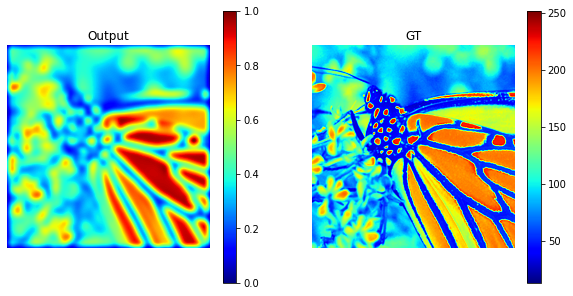

--- 2.0689995288848877 seconds for epoch ---
Epoch:  8 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


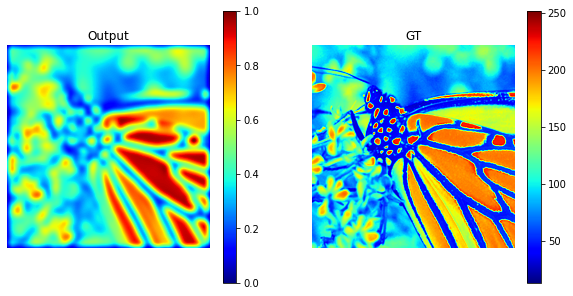

--- 1.9940009117126465 seconds for epoch ---
Epoch:  9 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


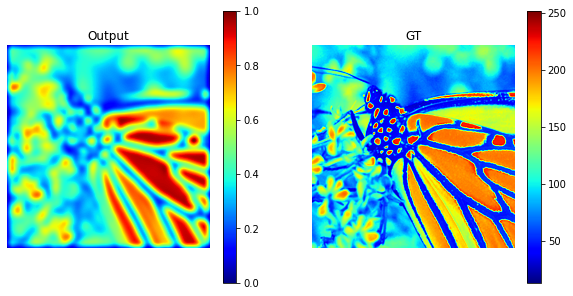

--- 2.022998809814453 seconds for epoch ---
Epoch:  10 / 10 , loss:  15427.130859375 Mean absoluate error:  124.21565246582031
*****Shape of the X***** (1, 1024, 1024, 1)
(1, 1024, 1024, 1)


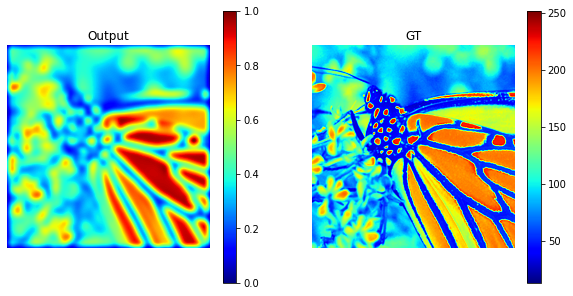

--- 2.0929999351501465 seconds for epoch ---


"\npred = model.predict_on_batch(Input)\n\nplt.figure(figsize=(10, 5))\nplt.subplot(1,2,1)\nplt.imshow(np.squeeze(pred),cmap='gray')\nplt.colorbar()\nplt.title('Output')\nplt.axis('off') \nplt.subplot(1,2,2)\nplt.imshow(np.squeeze(GT),cmap='gray')\nplt.colorbar()\nplt.title('GT')\nplt.axis('off') \nplt.show()\n"

In [5]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=2, sy=2):
    return 1. / (2. * 3.141592653 * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
x = np.linspace(-5, 5, num = 1024)
y = np.linspace(-5, 5, num = 1024)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
GT= np.array(im)
GT= GT[np.newaxis,:,:,np.newaxis]
#GT = gaus2d(x, y).astype(np.float32) # Here we use a Gaussian Mask as an example of ground truth
#GT = (GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))
#GT = GT[0:-1:20, 0:-1:20]
GT = np.expand_dims(np.expand_dims(GT, axis = 2), axis = 0)
print('*****Shape of the GT*****',GT.shape)
Input= np.array(im)
Input= Input[np.newaxis,:,:,np.newaxis]
#Input = np.ones((1,1,1),dtype=np.float32)
print('*****Shape of the Input*****',Input.shape)
model = Doublet_Metalens_EDOF()

model.train(Input, GT, epochs=10, batch_size=1)
'''
pred = model.predict_on_batch(Input)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(pred),cmap='gray')
plt.colorbar()
plt.title('Output')
plt.axis('off') 
plt.subplot(1,2,2)
plt.imshow(np.squeeze(GT),cmap='gray')
plt.colorbar()
plt.title('GT')
plt.axis('off') 
plt.show()
'''
